# [Projeto Maratona de Filmes](https://insper.github.io/supercomp/projetos/)

## Etapa 1: Adaptação do gerador e geração de múltiplos inputs

### 1.1. Adaptando o gerador
Somente uma adaptação foi realizada no funcionamento no gerador: a alteração da distribuição utilizada para gerar o número máximo de filmes para cada categoria. 

Inicialmente, a distribuição utilizada, tinha como limite superior o número de categorias existentes. Isso gerava um número máximo de filmes por categoria muito alto em alguns casos. Além disso, conforme o número de categorias aumentava, a média de filmes por categoria também crescia, fazendo com que esse limite não fosse tão relevante para inputs com alto número de categorias.

Como julgou-se que o limite de categorias deveria sempre ser relevante, alterou-se o código do gerador.

No caso, a distribuição foi alterada para que o limite superior fosse fixo e definido por um número arbitrário (10 foi escolhido, por ser o número médio de categorias). Como resultado, o limite de filmes por categoria pode manter uma relevância mais constante. Isso, por fim, permite manter um foco maior na variação do número de categorias, sem precisar levar em conta o aumento de seus limites.

### Código do gerador

```cpp
uniform_int_distribution<int> cat_limit(1, 10); // Novo gerador para o máximo de filmes por categoria
uniform_int_distribution<int> distribution_hr(0, 23);
uniform_int_distribution<int> distribution_cat(1, m); // Permanece sendo utilizado para gerar a categoria de cada filme

vector<int> maxFilmes(m); // Vetor para armazenar o máximo de filmes por categoria
for (int i = 0; i < m; i++)
{
    maxFilmes[i] = cat_limit(generator); // Gerando o máximo de filmes para cada categoria (alteração)
    inputFile << maxFilmes[i] << " ";    // Escrevendo o valor no arquivo de entrada
}
```

### 1.2. Geração de múltiplos inputs (`./code/gerador_multiple_cat_limit.cpp`)

Para realizar a geracão de múltiplos inputs, também foi necessário realizar algumas adaptações no código do gerador.

No caso, o que anteriormente era a função `main` foi transformada na função `void generate_tests(int n, int m, string file_name)`, que recebe como parâmetros o número de filmes a serem gerados, o número de categorias e o nome do arquivo de saída.

Dessa forma, criou-se um novo `main` que chama a função `generate_tests` para gerar os inputs de acordo com os parâmetros passados. Nesse `main` defini-se o número mínimo e máximo de filmes e categorias, que depois são combinados para gerar os inputs (podendo-se também configurar o step entre filmes ou categorias).

### Código do novo main do gerador

```cpp
int main(int argc, char *argv[])
{
    int min_categories = 1;
    int max_categories = 20;
    int min_movies = 0;
    int max_movies = 25000;
    int total = (max_categories - min_categories) * (max_movies - min_movies) / 50;

    for (int i = 1; i <= 50; i++)
    {
        for (int j = 1; j < 20; j++)
        {
            string file_name = "./input/input_" + to_string(i) + '_' + to_string(j) + ".txt";
            generate_tests(i, j, file_name);
        }
    }

    for (int i = min_movies; i <= max_movies; i += 50)
    {
        for (int j = min_categories; j < max_categories; j++)
        {
            string file_name = "./input/input_" + to_string(i) + '_' + to_string(j) + ".txt";
            generate_tests(i, j, file_name);
            total--;
            if (total % 1000 == 0)
                cout << total << endl;
        }
    }
    cout << total << endl;

    return 0;
}
```	

## Etapa 2: Implementação da [Heurística Gulosa](https://insper.github.io/supercomp/projetos/heuristico/)

### 2.1 Definir Regras

Antes de implementar o algoritmo, foi necessário definir as regras que seriam utilizadas para a resolução do problema. Elas foram:

1. Filmes que começam em um dia e terminam no outro são desconsiderados (Ex: inicio=23 e fim=2).
2. Filmes que começam e terminam no mesmo horário são desconsiderados (Ex: inicio=23 e fim=23).

<a id='regras'></a>

### 2.2 O Algoritmo Guloso

O objetivo dessa etapa é implementar um algoritmo que utiliza uma abordagem gulosa para resolver o problema. Os pré-requisitos para a implementação são:
1. Ordenar os filmes por hora de fim crescente.
2. Escolher aqueles que começam primeiro e não conflitam com os filmes já escolhidos.
3. Verificar se há vagas disponíveis na categoria do filme.

### 2.3 Implementação

A implementação do algoritmo guloso foi feita em C++. O código está disponível no arquivo `./code/greedy.cpp` (a partir da raiz do projeto) e foi compilado utilizando o compilador `g++` com o comando `g++ -g ./code/greedy.cpp -Wall -O3 -o ./greedy`.

### 2.3.2 Arquivos Header

Existe um arquivo header `./code/movie.h` que contém a definição da struct `Movie`. Essa struct é utilizada para representar os filmes e suas informações.

### 2.3.2 Funções auxiliares

1. `vector<int> setCategoryVector(int totalCategories)`
- Função que cria um vetor com o número de filmes por categoria.
- Recebe como parâmetro o número total de categorias.
- Retorna um vetor com o número de filmes por categoria.
- Categoria 1 = vetor[0], Categoria 2 = vetor[1], etc.
    
2. `vector<Movie> setMovieVector(int totalMovies)`
- Função que cria um vetor com os filmes.
- Recebe como parâmetro o número total de filmes.
- Retorna um vetor com os filmes (struct Movie).

3. `bool tryToAddMovie(vector<Movie> &watchlist, Movie &movie, bool timetable[24], int &freeSlots)`
- Função que tenta adicionar um filme na watchlist.
- Recebe como parâmetro a watchlist, o filme a ser adicionado, o array de horários disponíveis e o número de vagas disponíveis.
- Caso os horários que o filme em questão ocupa estejam disponíveis na `timetable`, modifica a `watchlist` (adiciona o filme), o array de horários disponíveis (torna os horários do filme como true (ocupados)) e o número de vagas disponíveis (decrementa o número de horas disponíveis na `timetable`).
- Retorna um booleano indicando se o filme foi adicionado ou não.

4. `bool sortSmallerDuration(Movie &i, Movie &j) { return i.duration < j.duration; }`
- Função que compara dois filmes pelo tempo de duração.
- Recebe como parâmetro dois filmes.
- Retorna um booleano indicando se o primeiro filme tem duração menor que o segundo.

5. `bool sortSmallerEndTime(Movie &i, Movie &j) { return i.endTime < j.endTime; }`
- Função que compara dois filmes pelo horário de término.
- Recebe como parâmetro dois filmes.
- Retorna um booleano indicando se o primeiro filme termina antes do segundo.

6. `bool sortSmallerId(Movie &i, Movie &j) { return i.id < j.id; }`
- Função que compara dois filmes pelo id.
- Recebe como parâmetro dois filmes.
- Retorna um booleano indicando se o primeiro filme tem id menor que o segundo.

7. `void printResult(vector<Movie> &watchlist, bool timetable[24])`
- Função que faz um output gráfico do resultado.
- Recebe como parâmetro a watchlist e o array de horários disponíveis.
- Não retorna nada.

### 2.3.3 Variáveis

1. `bool timetable[24]`
- Array de booleanos que indica se um horário do dia está ocupado ou não.
- Inicialmente nenhum horário está ocupado (false).
- Ex: 10 até 11 da manhã = timetable[10]

2. `int freeTimetableSlots`
- Inteiro que indica quantos horários ainda estão vagos
- Inicialmente todos (24)

3. `int totalMovies`
- Inteiro que indica o número total de filmes do input
    
4. `int totalCategories`
- Inteiro que indica o número total de categorias do input

5. `vector<int> categoryCount`
- Vetor que indica quantos filmes uma categoria ainda tem disponivel
- Inicialmente o número máximo de filmes por categoria
- Categoria 1 = vetor[0], Categoria 2 = vetor[1], etc.

6. `vector<Movie> movies`
- Vetor que possui todos os filmes disponíveis no arquivo de input

7. `vector<Movie> watchlist`
- Vetor que indica os filmes selecionados para serem assistidos
- Inicialmente vazio


### 2.3.3 Funcionamento do código:

#### a. Inicialização
1. Inicializa `timetable` e `freeTimetableSlots`
2. Declara `totalMovies` e `totalCategories`
3. Lê os dois primeiros valores do arquivo e determina `totalMovies` e `totalCategories`
4. Inicializa `categoryCount` utilizando a função `setCategoryVector(totalCategories)`
5. Inicializa `movies` utilizando a função `setMovieVector(totalMovies)`
6. Declara `watchlist`
7. Ordena `movies` por hora de fim crescente utilizando as funções `sort` e `sortSmallerEndTime`

#### b. Loop principal por todos os filmes do vetor movies
1. Verifica se `freeTimetableSlots` é igual a 0 (indica que não existem mais horários livres). Caso verdadeiro, encerrra o loop, pois não é possível adicionar mais filmes. 

2. Verifica se o horário de início do filme é maior que o de término ou se o filme começa e termina no mesmo horário ([Regras da etapa 2.1](#regras)). Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop.

3. Verifica, por meio do vetor `categoryCount`, se o limite da categoria do filme em questão já foi atingido. Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop, pois não seria permitido adicionar o filme à watchlist, uma vez que os espaços de sua categoria já se esgotaram. 

4. Chama a função `tryToAddMovie`. Ela tenta adicionar o filme à `watchlist` e se conseguir, atualiza a `watchlist`, a `timetable`, a `freeTimetableSlots` e retorna `true`. Caso retorne `true`, atualiza o `categoryCount` da categoria do filme em questão, para diminuir os filmes disponíveis para essa categoria.

#### c. Output
1. Verifica se foi passado algum argumento ao rodar o código. Caso falso, organiza a `watchlist` pela ordem do ID de seus filmes. Para isso utiliza as funções `sort` e `sortSmallerId`. Por fim, chama a função `printResult` para fazer um output gráfico do resultado

2. Verifica se o argumento passado ao rodar o código é o de benchmark. Caso verdadeiro, realiza um output reduzido, para análise posterior.


    

![greedy](./greedy_output.png)

### 2.3.4 Exemplo de output

#### Output gráfico (realizado no windows):
O output gráfico mostra, a quantidade de filmes selecionados (Movies to watch) e a quantiade de horários vazios na timetable (Free timetable slots).  

A seguir ele apresenta uma tabela, dividida por pipes, que possui as colunas ID (ID do filme), Start Time (hora de início do filme), End Time (hora de término do filme) e Category (categoria do filme).

No caso, cada linha após o header da tabela representa um dos filmes presentes na watchlist.

![greedy](./greedy_output.png)

#### Output reduzido para benchmark (realizado no windows):
O output para benchmark retorna apenas a quantidade de filmes na watchlist e o número de horários vagos na timetable

![greedy_benchmark](./greedy_benchmark_output.png)


## Etapa 3: Implementação da [Heurística Gulosa com Aleatoriedade](https://insper.github.io/supercomp/projetos/local/)

### 3.1 O Algoritmo Guloso com Aleatoriedade

O objetivo dessa etapa é adicionar um componente de aleatoriedade ao algoritmo guloso implementado previamente. O objetivo dessa etapa é permitir que a solução tenha um pouco mais de exploration e possa-se obter resultados melhores. Os pré-requisitos para a implementação são:
1. Ordenar os filmes por hora de fim crescente.
2. Escolher aqueles que começam primeiro e não conflitam com os filmes já escolhidos.
3. Verificar se há vagas disponíveis na categoria do filme.
4. Ao longo da seleção de um filme existir uma chance de 25% de pegar outro filme qualquer, que respeite o horário.

#### Detalhe -> Arquivos header e funções auxiliares permanecem os mesmos

### 3.2 Implementação

A implementação do algoritmo guloso com aleatoriedade foi feita em C++. O código está disponível no arquivo `./code/greedy_random.cpp` (a partir da raiz do projeto) e foi compilado utilizando o compilador `g++` com o comando `g++ -g ./code/greedy_random.cpp -Wall -O3 -o ./greedy_random`.

### 3.2.1 Variáveis adicionadas ao código

1. `default_random_engine generator`
- Gerador de números aleatórios
- Inicialmente com seed 10

2. `uniform_real_distribution<double> distribution(0.0, 1.0)`
- Distribuição uniforme de números aleatórios entre 0 e 1
- Utilizado para decidir se um filme aleatório será adicionado à watchlist

3. `int i = 1`
- Inteiro que indica a posição do filme que está sendo analisado
- Inicialmente 1, pois deve permanecer 1 a frente do filme que está sendo analisado


### 3.2.2 Funcionamento do código:

#### a. Inicialização
1. Inicializa `timetable` e `freeTimetableSlots`
2. Declara `totalMovies` e `totalCategories`
3. Lê os dois primeiros valores do arquivo e determina `totalMovies` e `totalCategories`
4. Inicializa `categoryCount` utilizando a função `setCategoryVector(totalCategories)`
5. Inicializa `movies` utilizando a função `setMovieVector(totalMovies)`
6. Declara `watchlist`
7. Ordena `movies` por hora de fim crescente utilizando as funções `sort` e `sortSmallerEndTime`
8. [+] Inicializa `generator` com seed 10 
9. [+] Inicializa `distribution` com valores entre 0 e 1
10. [+] Inicializa `i` com 1

#### b. Loop principal por todos os filmes do vetor movies
1. Verifica se `freeTimetableSlots` é igual a 0 (indica que não existem mais horários livres). Caso verdadeiro, encerrra o loop, pois não é possível adicionar mais filmes. 

2. [+] Verifica se o horário de início do filme é maior que o de término ou se o filme começa e termina no mesmo horário ([Regras da etapa 2.1](#regras)). Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop e incrementado o contador `i`.

3. [+] Verifica, por meio do vetor `categoryCount`, se o limite da categoria do filme em questão já foi atingido. Caso verdadeiro, não considera o filme em questão, pulando para a próxima iteração do loop, pois não seria permitido adicionar o filme à watchlist, uma vez que os espaços de sua categoria já se esgotaram. Em seguida, incrementa o contador `i`.

4. Chama a função `tryToAddMovie`. Ela tenta adicionar o filme à `watchlist` e se conseguir, atualiza a `watchlist`, a `timetable`, a `freeTimetableSlots` e retorna `true`. Caso retorne `true`, atualiza o `categoryCount` da categoria do filme em questão, para diminuir os filmes disponíveis para essa categoria.

5. [+] Verifica se o número aleatório gerado por `distribution(generator)` é maior que 0.75 (25% de chance) e se o valor do contador `i` é menor que `totalMovies` (caso falso, continua a partir do final do `if`).
    5.1 Caso verdadeiro, gera um número aleatório entre `i` e `totalMovies` (entre o próximo filme do vetor e o último) e o salva na variável local `p`.   

    5.2 Verifica se a categoria do filme já foi preenchida (caso verdadeiro, incrementa `i` e pula para a próxima iteração do loop).   

    5.3 Caso a categoria não tenha sido preenchida, chama a função `tryToAddMovie`, que tenta adicionar um o filme aleatório à `watchlist` e se conseguir, atualiza a `watchlist`, a `timetable`, a `freeTimetableSlots` e retorna `true`.   

    5.4 Se `tryToAddMovie` retornar `true`, atualiza o `categoryCount` da categoria do filme aleatório em questão, para diminuir os filmes disponíveis para essa categoria, deleta o filme do vetor `movies` e diminui em 1 o valor de totalMovies, pois agora existe um filme a menos no vetor.

6. [+] Incrementa em 1 o contador `i`.

#### c. Output
1. Verifica se foi passado algum argumento ao rodar o código. Caso falso, organiza a `watchlist` pela ordem do ID de seus filmes. Para isso utiliza as funções `sort` e `sortSmallerId`. Por fim, chama a função `printResult` para fazer um output gráfico do resultado

2. Verifica se o argumento passado ao rodar o código é o de benchmark. Caso verdadeiro, realiza um output reduzido, para análise posterior.

### 3.2.3 Output 

#### Permanece no mesmo formato da solução gulosa

## Etapa 4: Profiling (valgrind)

### 4.1 Comandos utilizados

1. `g++ -g greedy.cpp -Wall -O3 -o ./greedy` (para compilar o código)
2. `valgrind --tool=callgrind ./greedy --benchmark < input_200_10.txt` (para rodar o código com o valgrind)
3. `callgrind_annotate --threshold=0.01 callgrind.out.43819 greedy.cpp > greedy_profiling.txt` (para gerar o arquivo de profiling e remover linhas de código que representem menos de 1% do total de ciclos ou instruções)
4. Repetir os passos para o código da solução gulosa com aleatoriedade e salvar em `greedy_random_profiling.txt` 

### 4.2 Resultados solução gulosa

Ao analisar o arquivo de profiling, pode-se fazer algumas observações:

1. Uma boa parte do tempo é gasta na função "_dl_lookup_symbol_x" do arquivo "dl-new-hash.h". Essa função faz parte da biblioteca padrão do C no GNU e é tem a função de fazer buscas de símbolos em bibliotecas dinâmicas. Por ser uma função padrão, está fora do escopo do projeto, mas talvez seja possível otimiá-la, caso seja possível identificar o motivo de sua utilização.

2. As funções "setMovieVector" e "setCategoryVector" do arquivo "greedy.cpp" gastaram 25,23% e 0,42% do tempo, respectivamente, e juntas representam mais de um quarto do tempo total. Isso sugere que há oportunidades para melhorar o desempenho examinando essas funções. Por se tratar de funções que inicializam os vetores de filmes e categorias, talvez fosse possível otimizar seu tempo de execução, por exemplo, utilizando alocação dinâmica de memória. Além disso, a leitura de entrada com "cin" também gastou uma quantidade significativa de tempo.


### 4.3 Resultados solução gulosa com aleatoriedade

Ao analisar o arquivo de profiling, pode-se notar que suas características são muito semelhantes às da solução gulosa. A única diferença que se pode notar é que a função "setMovieVector" gastou 25,12% do tempo (um pouco menos que a da solução gulosa, mas por ser exatamente a mesma função, provavelmente se deve a uma pequena diferença na leitura de entrada).

Além disso, em uma das ocasioes, a função "tryToAddMovie" gastou 0,04% do tempo, que apesar de ser um valor muito pequeno, é maior que o tempo gasto pela mesma função na solução gulosa (gasto menor que 0,01% dos ciclos totais).

### 4.4 Conclusões

Ambas as soluções possuem alto consumo de ciclos de processador nos mesmos pontos, o que indica que o gargalo do código está na leitura de entrada e na inicialização dos vetores de filmes e categorias.


## Etapa 5: Benchmark e comparação de resultados

### 5.1 Automatizando teste de diferentes inputs

Para poder testar múltiplos inputs para as duas heurísticas elaboradas, criou-se o script `./benchmark.py` (em relação a raiz do projeto). Esse script roda todos os arquivos de teste presente na pasta `./input` para um executável selecionado. Para cada arquivo de teste, esse script escreve uma linha de um arquivo `.txt` com o nome do arquivo de teste, o Stdout (output para benchmark: quantidade de filmes na watchlist e número de horários vagos na timetable), o Stderr caso haja e tempo total em segundos para rodar o programa para aquele arquivo de teste.

### 5.2 Resultados

Os resultados para o algoritmo guloso foram salvos no arquivo `./greedy_benchmark.txt` e para o algoritmo guloso com aleatoriedade no arquivo `./greedy_random_benchmark.txt`. Os resultados foram obtidos utilizando o executável `./greedy` e `./greedy_random` respectivamente.

#### 5.2.1 Leitura dos resultados e pre-processamento

In [17]:
# Lendo os resultados do benchmark e fazendo pre-processamento:

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

df_greedy = pd.read_csv("../greedy_benchmark.txt", sep="|")
df_greedy_random = pd.read_csv("../greedy_random_benchmark.txt", sep="|")

# Rename columns to name stripped:
df_greedy.columns = df_greedy.columns.str.strip()
df_greedy_random.columns = df_greedy_random.columns.str.strip()


# Column Stdout is composed of the following: {movies to watch} {free timetable slots}
# Convert it to two columns:
df_greedy[["movies_to_watch", "free_timetable_slots"]] = df_greedy["Stdout"].str.split(" ", expand=True)
df_greedy_random[["movies_to_watch", "free_timetable_slots"]] = df_greedy_random["Stdout"].str.split(" ", expand=True)

df_greedy["movies_to_watch"] = df_greedy["movies_to_watch"].astype(int)
df_greedy_random["movies_to_watch"] = df_greedy_random["movies_to_watch"].astype(int)
df_greedy["free_timetable_slots"] = df_greedy["free_timetable_slots"].astype(int)
df_greedy_random["free_timetable_slots"] = df_greedy_random["free_timetable_slots"].astype(int)

In [18]:
# assert stderr is empty:
assert df_greedy["Stderr"].isnull().all()
assert df_greedy_random["Stderr"].isnull().all()

In [19]:
# remove unnecessary columns:
df_greedy.drop(columns=["Stdout", "Stderr"], inplace=True)
df_greedy_random.drop(columns=["Stdout", "Stderr"], inplace=True)

In [20]:
# the column input file to two columns:
df_greedy["Input File"] = df_greedy["Input File"].str.replace("input_", "")
df_greedy["Input File"] = df_greedy["Input File"].str.replace(".txt", "")
df_greedy[["total_movies", "total_categories"]] = df_greedy["Input File"].str.split("_", expand=True)
df_greedy["total_movies"] = df_greedy["total_movies"].astype(int)
df_greedy["total_categories"] = df_greedy["total_categories"].astype(int)

df_greedy_random["Input File"] = df_greedy_random["Input File"].str.replace("input_", "")
df_greedy_random["Input File"] = df_greedy_random["Input File"].str.replace(".txt", "")
df_greedy_random[["total_movies", "total_categories"]] = df_greedy_random["Input File"].str.split("_", expand=True)
df_greedy_random["total_movies"] = df_greedy_random["total_movies"].astype(int)
df_greedy_random["total_categories"] = df_greedy_random["total_categories"].astype(int)

C:\Users\franb\AppData\Local\Temp\ipykernel_10948\3861184555.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_greedy["Input File"] = df_greedy["Input File"].str.replace(".txt", "")
C:\Users\franb\AppData\Local\Temp\ipykernel_10948\3861184555.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_greedy_random["Input File"] = df_greedy_random["Input File"].str.replace(".txt", "")


In [21]:
# Topo do dataframe com os resultados do greedy:
df_greedy.head(10)

,Input File,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
0,10000_1,0.022025,8,16,10000,1
1,10000_10,0.022819,23,1,10000,10
2,10000_11,0.022546,23,1,10000,11
3,10000_12,0.022607,23,1,10000,12
4,10000_13,0.022680,23,1,10000,13
5,10000_14,0.022718,23,1,10000,14
6,10000_15,0.022827,23,1,10000,15
7,10000_16,0.023614,23,1,10000,16
8,10000_17,0.022657,23,1,10000,17
9,10000_18,0.022469,23,1,10000,18


In [22]:
# Topo do dataframe com os resultados do greedy_random:
df_greedy_random.head(10)

,Input File,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
0,10000_1,0.022289,8,5,10000,1
1,10000_10,0.024761,15,1,10000,10
2,10000_11,0.022734,12,1,10000,11
3,10000_12,0.022030,14,1,10000,12
4,10000_13,0.021315,10,1,10000,13
5,10000_14,0.025569,11,1,10000,14
6,10000_15,0.021930,13,1,10000,15
7,10000_16,0.022065,13,1,10000,16
8,10000_17,0.021025,12,1,10000,17
9,10000_18,0.021670,10,1,10000,18


#### 5.2.2 Análise dos resultados

In [23]:
# Comparacao entre o describe dos dois dataframes:
df_greedy.describe()

,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
count,10431.000000,10431.000000,10431.000000,10431.000000,10431.000000
mean,0.029074,19.351548,3.711916,11409.335155,10.000000
std,0.116148,6.422768,5.291460,7755.090334,5.477488
min,0.007259,0.000000,1.000000,1.000000,1.000000
25%,0.017011,18.000000,1.000000,4450.000000,5.000000
50%,0.027519,23.000000,1.000000,11300.000000,10.000000
75%,0.037880,23.000000,4.000000,18150.000000,15.000000
max,11.601778,23.000000,24.000000,25000.000000,19.000000


In [24]:
df_greedy_random.describe()

,Tempo total(s),movies_to_watch,free_timetable_slots,total_movies,total_categories
count,10431.000000,10431.000000,10431.000000,10431.000000,10431.000000
mean,0.025966,10.638002,2.546544,11409.335155,10.000000
std,0.012604,2.737914,3.970084,7755.090334,5.477488
min,0.006923,0.000000,1.000000,1.000000,1.000000
25%,0.015157,10.000000,1.000000,4450.000000,5.000000
50%,0.024889,11.000000,1.000000,11300.000000,10.000000
75%,0.035712,12.000000,1.000000,18150.000000,15.000000
max,0.086484,19.000000,24.000000,25000.000000,19.000000


Ao analisar o resumo dos resultados das duas heuristicas, percebe-se que a heuristica gulosa com aleatoriedade apresenta em média uma menor quantidade de filmes na watchlist e um menor número de horários vagos na timetable em relação à heuristica gulosa. Como o objetivo do problema é maximizar a quantidade de filmes na watchlist, a heuristica gulosa (sem aleatoriedade) parece ser a melhor solução para o problema. Caso o objetivo fosse minimizar o número de horários vagos na timetable, a heuristica gulosa com aleatoriedade seria a melhor solução.

In [25]:
# Remove outliers:
Q1 = df_greedy.quantile(0.1)
Q3 = df_greedy.quantile(0.9)
IQR = Q3 - Q1

df_greedy = df_greedy[~((df_greedy < (Q1 - 1.5 * IQR)) | (df_greedy > (Q3 + 1.5 * IQR))).any(axis=1)]
df_greedy_random = df_greedy_random[~((df_greedy_random < (Q1 - 1.5 * IQR)) | (df_greedy_random > (Q3 + 1.5 * IQR))).any(axis=1)]

C:\Users\franb\AppData\Local\Temp\ipykernel_10948\2953797026.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df_greedy.quantile(0.1)
C:\Users\franb\AppData\Local\Temp\ipykernel_10948\2953797026.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df_greedy.quantile(0.9)
C:\Users\franb\AppData\Local\Temp\ipykernel_10948\2953797026.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_greedy = df_greedy[~((df_greedy < (Q1 - 1.5 * IQR)) | (df_greedy > (Q3 + 

## Total de filmes Vs. Tempo de execução

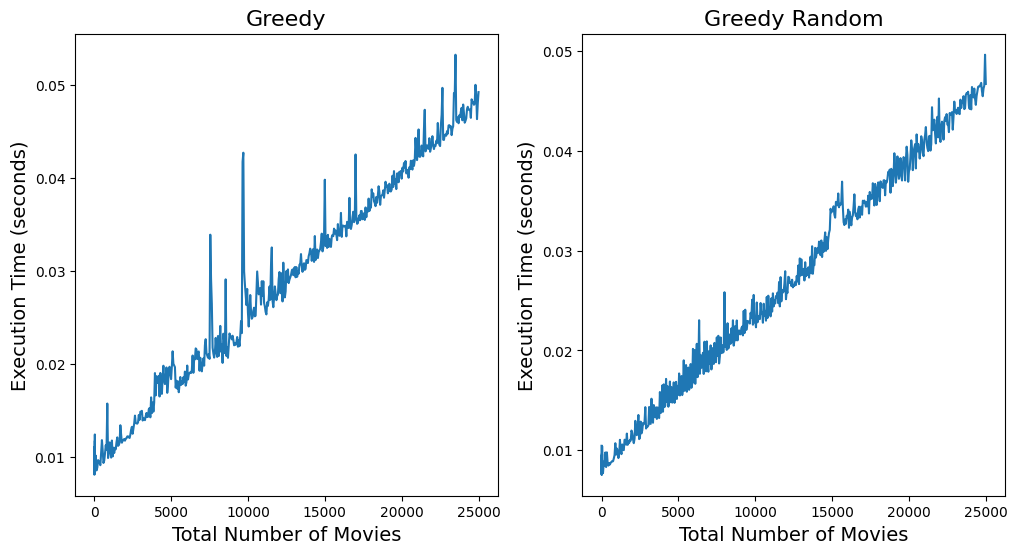

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_mov_greedy = df_greedy[['total_movies', 'Tempo total(s)']]
df_mov_greedy_rand = df_greedy_random[['total_movies', 'Tempo total(s)']]

# Group the data by the total number of categories and compute the mean execution time for each group
df_mov_greedy_gr = df_mov_greedy.groupby('total_movies').mean()
df_mov_greedy_rand_gr = df_mov_greedy_rand.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='Tempo total(s)', data=df_mov_greedy_gr, ax=axs[0])
sns.lineplot(x='total_movies', y='Tempo total(s)', data=df_mov_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Movies', fontsize=14)
axs[1].set_xlabel('Total Number of Movies', fontsize=14)
axs[0].set_ylabel('Execution Time (seconds)', fontsize=14)
axs[1].set_ylabel('Execution Time (seconds)', fontsize=14)

plt.show()

## Total de categorias Vs. Tempo de execução

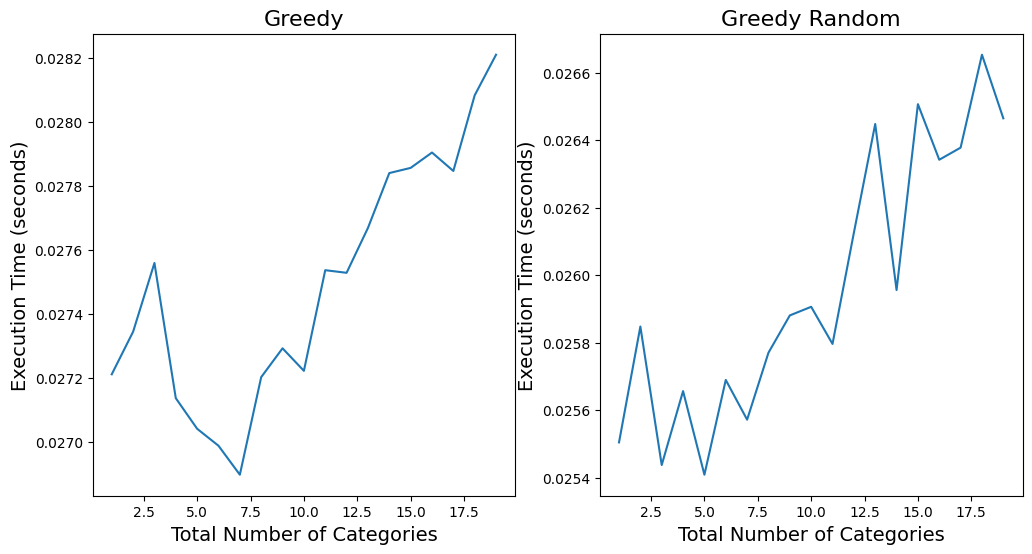

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_cat_greedy = df_greedy[['total_categories', 'Tempo total(s)']]
df_cat_greedy_rand = df_greedy_random[['total_categories', 'Tempo total(s)']]

# Group the data by the total number of categories and compute the mean execution time for each group
df_cat_greedy_gr = df_cat_greedy.groupby('total_categories').mean()
df_cat_greedy_rand_gr = df_cat_greedy_rand.groupby('total_categories').mean()

sns.lineplot(x='total_categories', y='Tempo total(s)', data=df_cat_greedy_gr, ax=axs[0])
sns.lineplot(x='total_categories', y='Tempo total(s)', data=df_cat_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Categories', fontsize=14)
axs[1].set_xlabel('Total Number of Categories', fontsize=14)
axs[0].set_ylabel('Execution Time (seconds)', fontsize=14)
axs[1].set_ylabel('Execution Time (seconds)', fontsize=14)

plt.show()


#### Total de filmes vs Tempo de execução

Agrupou-se os dados por quantidade de filmes e calculou-se a média do tempo de execução para cada quantidade de filmes. Com isso, foi possível plotar um gráfico que mostra a relação entre o tempo de execução e o número total de filmes por arquivo, para cada grupo de filmes.

Ao analisar o gráfico, pode-se perceber que o tempo de execução aumenta de forma linear com o número total de filmes, tanto para o algoritmo guloso quanto para o algoritmo guloso com aleatoriedade. Isso indica que o tempo de execução do algoritmo é proporcional ao número total de filmes, o que é esperado, já que o algoritmo precisa iterar por todos os filmes ou até que não haja mais horários livres (o que nem sempre acontece). 

Além disso, é possível perceber uma quantidade significativa de ruído em ambos os gráficos, o que pode ser explicado pelo fato de que o tempo de execução de cada arquivo de teste é diferente, e depende de multiplas variáveis.

#### Total de categorias vs Tempo de execução

O mesmo agrupamento foi realizado para o número total de categorias. Nesse caso, o agrupamento foi feito por quantidade de categorias e o tempo de execução foi calculado para cada quantidade de categorias.

Ao analisar ambos os gráficos, pode-se perceber que ambos aparentam apresentar uma correlação positiva entre o tempo de execução e o número total de categorias, mas que não se pode dizer com certeza que é linear. Além disso, essa correlação parece ser fraca e a taxa de crescimento total é pequena.

Também é possível perceber que ambos os gráficos apresentam um vale ao redor de 5 a 7 categorias. Isso pode ser explicado tanto pelo fato de ambas heuristicas utilizarem os mesmos arquivos de teste, ou pelo fato de que talvez exista uma quantidade de categorias não ideal para o problema, ou ainda por uma combinação dos dois.

De certa forma é dificil concluir alguma coisa sobre a relação entre o tempo de execução e o número total de categorias, já que apesar dos dois gráficos apresentarem um formato similar, não existe uma correlação muito clara. 

## Total de filmes Vs. Filmes na watchlist

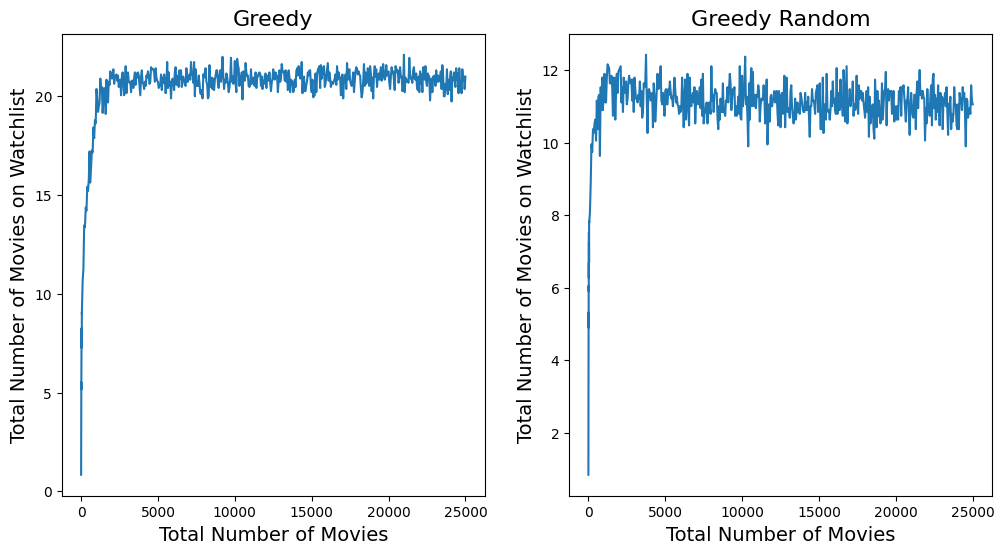

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_mov_greedy = df_greedy[['total_movies', 'movies_to_watch']]
df_mov_greedy_rand = df_greedy_random[['total_movies', 'movies_to_watch']]

# Group the data by the total number of movies and compute the mean amonunt of movies on watchlist for each group
df_mov_greedy_gr = df_mov_greedy.groupby('total_movies').mean()
df_mov_greedy_rand_gr = df_mov_greedy_rand.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='movies_to_watch', data=df_mov_greedy_gr, ax=axs[0])
sns.lineplot(x='total_movies', y='movies_to_watch', data=df_mov_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Movies', fontsize=14)
axs[1].set_xlabel('Total Number of Movies', fontsize=14)
axs[0].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)
axs[1].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)

plt.show()

## Total de categorias Vs. Filmes na watchlist

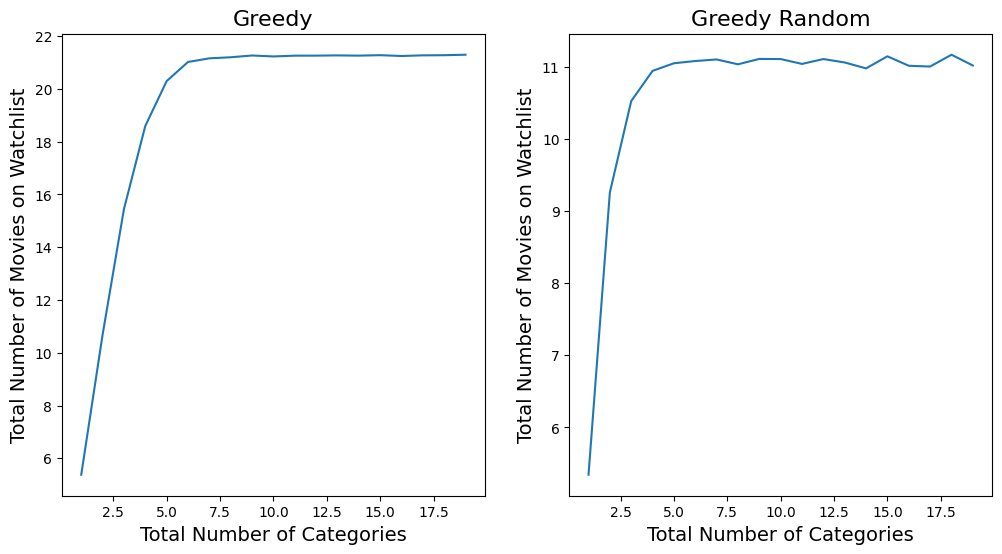

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_cat_greedy = df_greedy[['total_categories', 'movies_to_watch']]
df_cat_greedy_rand = df_greedy_random[['total_categories', 'movies_to_watch']]

# Group the data by the total number of categories and compute the mean amount of movies on the watchlist for each group
df_cat_greedy_gr = df_cat_greedy.groupby('total_categories').mean()
df_cat_greedy_rand_gr = df_cat_greedy_rand.groupby('total_categories').mean()

sns.lineplot(x='total_categories', y='movies_to_watch', data=df_cat_greedy_gr, ax=axs[0])
sns.lineplot(x='total_categories', y='movies_to_watch', data=df_cat_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Categories', fontsize=14)
axs[1].set_xlabel('Total Number of Categories', fontsize=14)
axs[0].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)
axs[1].set_ylabel('Total Number of Movies on Watchlist', fontsize=14)

plt.show()

#### Comparação entre o número de filmes na watchlist e o número total de filmes e categorias

Ao observar os gráficos gerados, tanto para o número total de filmes quanto para o número total de categorias, é possível perceber que ambos possuem uma curva de crescimento, que aparenta ser logarítmica. O formato desses gráficos é muito semelhante tanto entre as heuristicas, quanto entre número total de filmes e número total de categorias. 

Isso indica que o aumento do número total de filmes e categorias impacta muito o número de filmes na watchlist, mas apenas até um certo ponto. Após esse ponto, o número de filmes na watchlist não aumenta mais de forma significativa, mesmo que o número total de filmes e categorias aumente.

Por fim, pode-se também perceber que apesar dos gráficos serem muito parecido e consistentes entre as heuristicas, quando se trata do formato, pode-se notar que a heuristica gulosa com aleatoriedade performa constantemente pior que a heuristica gulosa. No gráfico que compara o número total de filmes ao total na watchlist, a heuristica gulosa tende à um valor de, aproximadamente, 21, enquanto a gulosa com aleatoriedade tende à um valor de, mais ou menos, 11. Essa têndencia se repete nos gráficos que comparam o número total de categorias ao total na watchlist.

Também pode-se notar que a heuristica gulosa apresenta mais ruído, mas isso é resultado da própria natureza do algoritmo, que é aleatório.	 

## Total de filmes Vs. Horários vagos na timetable

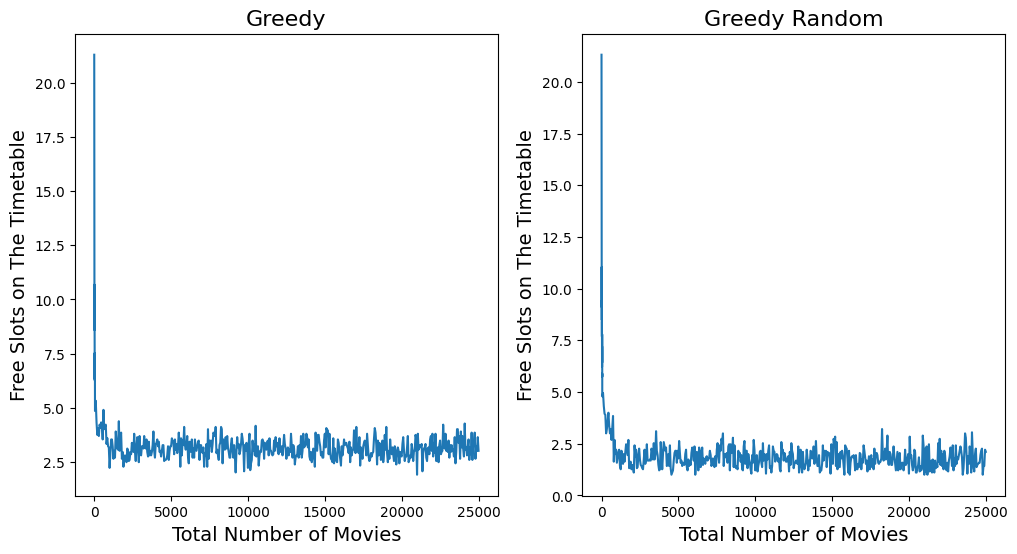

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_mov_greedy = df_greedy[['total_movies', 'free_timetable_slots']]
df_mov_greedy_rand = df_greedy_random[['total_movies', 'free_timetable_slots']]

# Group the data by the total number of movies and compute the mean number of free slots on the timetable for each group
df_mov_greedy_gr = df_mov_greedy.groupby('total_movies').mean()
df_mov_greedy_rand_gr = df_mov_greedy_rand.groupby('total_movies').mean()

sns.lineplot(x='total_movies', y='free_timetable_slots', data=df_mov_greedy_gr, ax=axs[0])
sns.lineplot(x='total_movies', y='free_timetable_slots', data=df_mov_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Movies', fontsize=14)
axs[1].set_xlabel('Total Number of Movies', fontsize=14)
axs[0].set_ylabel('Free Slots on The Timetable', fontsize=14)
axs[1].set_ylabel('Free Slots on The Timetable', fontsize=14)

plt.show()

## Total de categorias Vs. Horários vagos na timetable

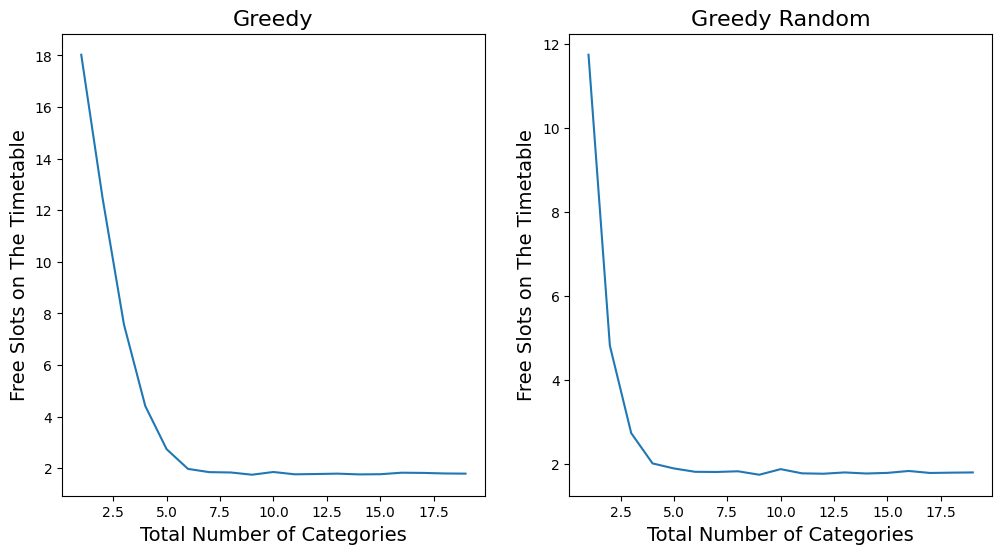

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Extract columns 
df_cat_greedy = df_greedy[['total_categories', 'free_timetable_slots']]
df_cat_greedy_rand = df_greedy_random[['total_categories', 'free_timetable_slots']]

# Group the data by the total number of categories and compute the mean number of free slots in the timetable for each group
df_cat_greedy_gr = df_cat_greedy.groupby('total_categories').mean()
df_cat_greedy_rand_gr = df_cat_greedy_rand.groupby('total_categories').mean()

sns.lineplot(x='total_categories', y='free_timetable_slots', data=df_cat_greedy_gr, ax=axs[0])
sns.lineplot(x='total_categories', y='free_timetable_slots', data=df_cat_greedy_rand_gr, ax=axs[1])

axs[0].set_title('Greedy', fontsize=16)
axs[1].set_title('Greedy Random', fontsize=16)

axs[0].set_xlabel('Total Number of Categories', fontsize=14)
axs[1].set_xlabel('Total Number of Categories', fontsize=14)
axs[0].set_ylabel('Free Slots on The Timetable', fontsize=14)
axs[1].set_ylabel('Free Slots on The Timetable', fontsize=14)

plt.show()

#### Comparação entre o número de horas não preenchidas por filmes e o número total de filmes e categorias

Ao observar os gráficos gerados, tanto para o número total de filmes quanto para o número total de categorias, é possível perceber que ambos possuem uma curva de decaimento, que aparenta ser logarítmica. O formato desses gráficos é muito semelhante tanto entre as heuristicas, quanto entre número total de filmes e número total de categorias. 

Isso indica que o aumento do número total de filmes e categorias impacta muito o número de horas não preenchidas por filmes, mas apenas até um certo ponto. Após esse ponto, o número de horas não preenchidas não diminui mais de forma significativa, mesmo que o número total de filmes e categorias aumente.

Por fim, pode-se também perceber que, quando trata-se do formato, apesar dos gráficos serem muito parecido e consistentes entre as heuristicas, pode-se notar que a heuristica gulosa com aleatoriedade performa constantemente melhor que a heuristica gulosa. No gráfico que compara o número total de filmes ao total de horas vagas, a heuristica gulosa tende à um valor entre 2.5 e 5, enquanto a gulosa com aleatoriedade tende à um valor abaixo de 2.5. 

Para o gráfico de número total de categorias vs. número de horas vagas, ambas possuem uma tendência de aproximadamente 2, mas a heuristica gulosa com aleatoriedade chega à esse valor mais rapidamente.

Também pode-se notar que a heuristica gulosa apresenta mais ruído, mas isso é resultado da própria natureza do algoritmo, que é aleatório.	 

## Etapa 6: Conclusão

No geral, o que pode-se perceber de relevante é que, para a tarefa dada de assistir o máximo de filmes possível, a heuristica gulosa performa melhor que a heuristica gulosa com aleatoriedade. No entanto, quando se trata de tempo de execução e minimização de horas vagas, a heuristica gulosa com aleatoriedade performa melhor.

Uma hipótese para esse resultado é que, a heuristica gulosa garante a seleção do número máximo de filmes que cabem no período de tempo e atendem aos limites da categoria. No entanto, essa abordagem pode resultar em filmes mais longos sendo selecionados primeiro, o que pode deixar menos opções para filmes mais curtos posteriormente.

Por outro lado, o segundo algoritmo introduz aleatoriedade no processo de seleção, o que às vezes pode levar a um uso mais eficiente do tempo de tela, pois pode selecionar filmes mais curtos no início do processo e deixar mais opções para filmes mais longos posteriormente. No entanto, existe o risco de o algoritmo selecionar muitos filmes aleatórios e poucos filmes de categorias específicas, levando a um uso ineficiente dos limites de categoria.

Em resumo, o algoritmo guloso sem aleatoriedade é mais determinístico e tende a priorizar o número de filmes assistidos, enquanto o segundo algoritmo (guloso com aleatoriedade) é mais aleatório e tende a priorizar a eficiência do tempo de tela, mas pode sacrificar alguns limites da categoria.